In [1]:
import tensorflow as tf
import matplotlib.pylab as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-01-03 18:01:04.039653: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-03 18:01:04.077274: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-03 18:01:04.077305: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-03 18:01:04.077312: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-03 18:01:04.083449: I tensorflow/core/platform/cpu_feature_g

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
def train_val_generators(TRAINING_DIR):

  # Instantiate the ImageDataGenerator class
  validation_split=0.1
  # Don't forget to normalize pixel values and set arguments to augment the images
  train_datagen = ImageDataGenerator(rescale=1./255, 
                                     validation_split=validation_split)

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=16,
                                                      class_mode='categorical',
                                                      target_size=(224, 224),
                                                      subset='training')
  
  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=16,
                                                      class_mode='categorical',
                                                      target_size=(224, 224),
                                                      subset='validation')

  return train_generator, validation_generator

In [4]:
train_dir = 'pisang/pisang_artificial_ripen/Train'

In [5]:
# Test generators
train_generator, validation_generator = train_val_generators(train_dir)

Found 7233 images belonging to 12 classes.
Found 800 images belonging to 12 classes.


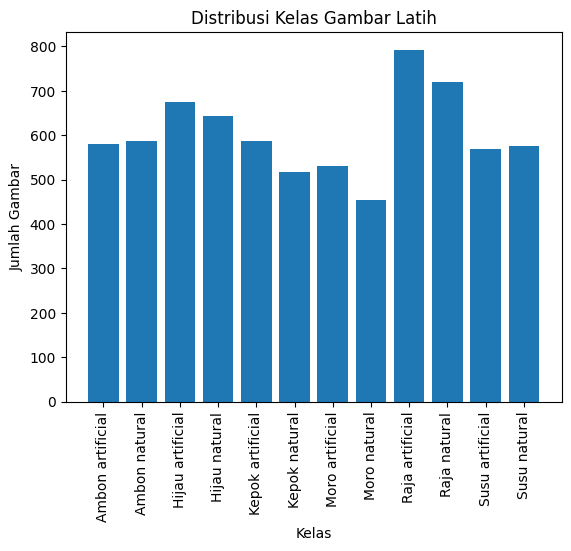

In [5]:
# Menghitung jumlah data per kelas
num_classes_train = len(train_generator.class_indices)
class_counts_train = np.zeros(num_classes_train)

for i in range(len(train_generator)):
    batch_labels_train = np.argmax(train_generator[i][1], axis=1)
    class_counts_train += np.bincount(batch_labels_train, minlength=num_classes_train)

# Mendapatkan nama kelas
class_names_train = list(train_generator.class_indices.keys())

plt.bar(class_names_train, class_counts_train)
plt.title('Distribusi Kelas Gambar Latih')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=90)
plt.show()

## ResNet152 SGD 0.1-0.0001

In [6]:
pretrained_resnet = tf.keras.applications.ResNet152(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet'
)

2024-01-03 18:01:09.834489: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 25104 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:af:00.0, compute capability: 7.5


In [7]:
x_resnet = pretrained_resnet.output
x_resnet = tf.keras.layers.GlobalAveragePooling2D()(x_resnet)
predictions_resnet = tf.keras.layers.Dense(12, activation='softmax')(x_resnet)
model = tf.keras.Model(inputs=pretrained_resnet.input, outputs=predictions_resnet)
#model.summary()

### 0,1 - 0,4

#### 0,1

In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
#pretrained_mobile.trainable = False
sgd = tf.keras.optimizers.SGD(learning_rate=0.1)
adam = tf.keras.optimizers.Adam(learning_rate=1e-6)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=["accuracy"])

filepath = 'new_test/new-test-resnet-sgd-0,1.h5'

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'max',
    save_freq = 'epoch'
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    verbose=1,
)
train_log=tf.keras.callbacks.CSVLogger(
    filename='new_test/new-test-resnet-sgd-0,1.log', 
    separator=','
)
callbacksList = [modelCheckpoint, train_log, early_stopping]
train_mobile = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=100,
                    callbacks = callbacksList,
                    verbose=1)
model.save('new_test/new-test-resnet-sgd-0,1-completed.h5')

Epoch 1/100


2024-01-02 19:16:07.410770: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2024-01-02 19:16:09.210572: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-02 19:16:09.537038: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-02 19:16:13.016089: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f60ca7ebb80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-02 19:16:13.016121: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2024-01-02 19:16:13.128309: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


453/453 [==============================] - ETA: 0s - loss: 1.3038 - accuracy: 0.4732
Epoch 1: val_accuracy improved from -inf to 0.07375, saving model to new_test/new-test-resnet-sgd-0,1.h5


/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


453/453 [==============================] - 245s 397ms/step - loss: 1.3038 - accuracy: 0.4732 - val_loss: 6.6951 - val_accuracy: 0.0737
Epoch 2/100
453/453 [==============================] - ETA: 0s - loss: 0.6995 - accuracy: 0.6649
Epoch 2: val_accuracy improved from 0.07375 to 0.14750, saving model to new_test/new-test-resnet-sgd-0,1.h5
453/453 [==============================] - 171s 378ms/step - loss: 0.6995 - accuracy: 0.6649 - val_loss: 3.7126 - val_accuracy: 0.1475
Epoch 3/100
453/453 [==============================] - ETA: 0s - loss: 0.4916 - accuracy: 0.7799
Epoch 3: val_accuracy improved from 0.14750 to 0.44625, saving model to new_test/new-test-resnet-sgd-0,1.h5
453/453 [==============================] - 171s 378ms/step - loss: 0.4916 - accuracy: 0.7799 - val_loss: 1.6224 - val_accuracy: 0.4462
Epoch 4/100
453/453 [==============================] - ETA: 0s - loss: 0.3711 - accuracy: 0.8424
Epoch 4: val_accuracy improved from 0.44625 to 0.46250, saving model to new_test/new-tes

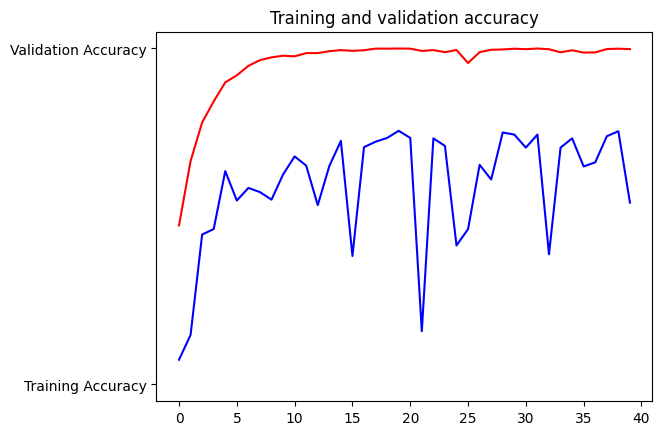

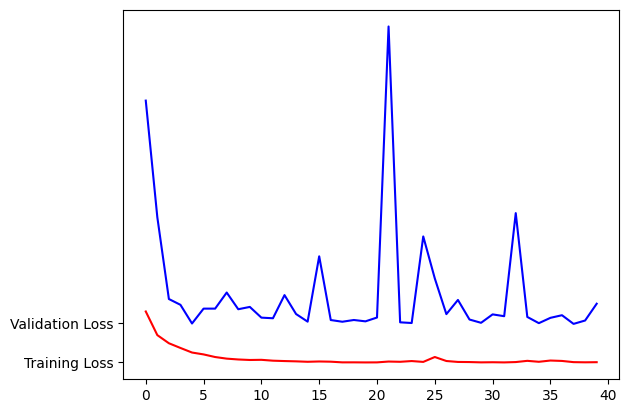

In [9]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc_mobile=train_mobile.history['accuracy']
val_acc_mobile=train_mobile.history['val_accuracy']
loss_mobile=train_mobile.history['loss']
val_loss_mobile=train_mobile.history['val_loss']

epochs2=range(len(acc_mobile)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs2, acc_mobile, 'r', "Training Accuracy")
plt.plot(epochs2, val_acc_mobile, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs2, loss_mobile, 'r', "Training Loss")
plt.plot(epochs2, val_loss_mobile, 'b', "Validation Loss")
plt.show()

#### 0,2

In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
#pretrained_mobile.trainable = False
sgd = tf.keras.optimizers.SGD(learning_rate=0.2)
adam = tf.keras.optimizers.Adam(learning_rate=1e-6)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=["accuracy"])

filepath = 'new_test/new-test-resnet-sgd-0,2.h5'

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'max',
    save_freq = 'epoch'
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    verbose=1,
)
train_log=tf.keras.callbacks.CSVLogger(
    filename='new_test/new-test-resnet-sgd-0,2.log', 
    separator=','
)
callbacksList = [modelCheckpoint, train_log, early_stopping]
train_mobile = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=100,
                    callbacks = callbacksList,
                    verbose=1)
model.save('new_test/new-test-resnet-sgd-0,2-completed.h5')

Epoch 1/100


2024-01-02 22:49:00.971439: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2024-01-02 22:49:02.667734: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-02 22:49:02.970665: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-02 22:49:06.285740: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x56410127ccc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-02 22:49:06.285802: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2024-01-02 22:49:06.386455: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


453/453 [==============================] - ETA: 0s - loss: 1.7376 - accuracy: 0.3564
Epoch 1: val_accuracy improved from -inf to 0.08000, saving model to new_test/new-test-resnet-sgd-0,2.h5


/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


453/453 [==============================] - 240s 387ms/step - loss: 1.7376 - accuracy: 0.3564 - val_loss: 2.9680 - val_accuracy: 0.0800
Epoch 2/100
453/453 [==============================] - ETA: 0s - loss: 0.9847 - accuracy: 0.5409
Epoch 2: val_accuracy improved from 0.08000 to 0.11250, saving model to new_test/new-test-resnet-sgd-0,2.h5
453/453 [==============================] - 171s 377ms/step - loss: 0.9847 - accuracy: 0.5409 - val_loss: 5.9344 - val_accuracy: 0.1125
Epoch 3/100
453/453 [==============================] - ETA: 0s - loss: 0.8264 - accuracy: 0.6045
Epoch 3: val_accuracy improved from 0.11250 to 0.46625, saving model to new_test/new-test-resnet-sgd-0,2.h5
453/453 [==============================] - 171s 377ms/step - loss: 0.8264 - accuracy: 0.6045 - val_loss: 1.1841 - val_accuracy: 0.4663
Epoch 4/100
453/453 [==============================] - ETA: 0s - loss: 0.7199 - accuracy: 0.6526
Epoch 4: val_accuracy did not improve from 0.46625
453/453 [============================

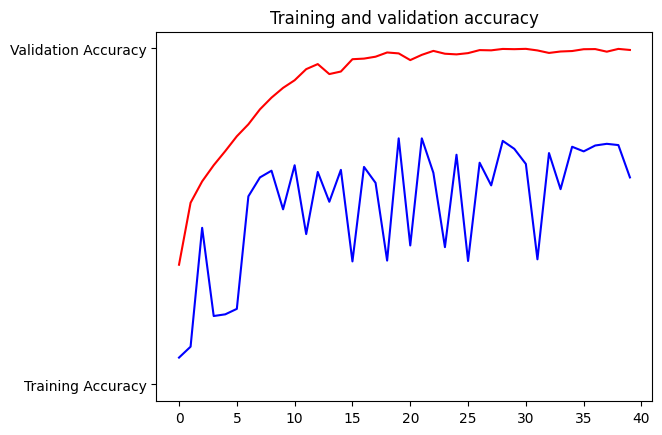

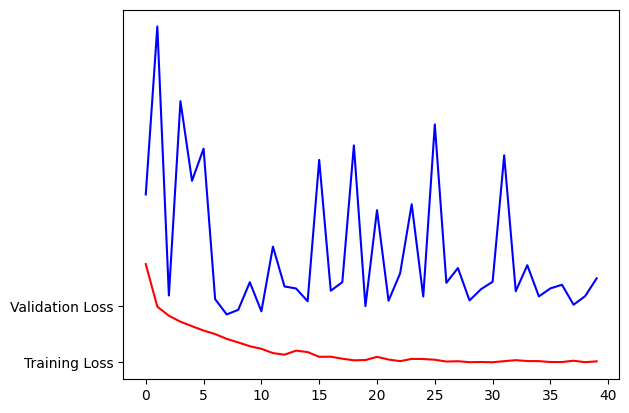

In [9]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc_mobile=train_mobile.history['accuracy']
val_acc_mobile=train_mobile.history['val_accuracy']
loss_mobile=train_mobile.history['loss']
val_loss_mobile=train_mobile.history['val_loss']

epochs2=range(len(acc_mobile)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs2, acc_mobile, 'r', "Training Accuracy")
plt.plot(epochs2, val_acc_mobile, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs2, loss_mobile, 'r', "Training Loss")
plt.plot(epochs2, val_loss_mobile, 'b', "Validation Loss")
plt.show()

#### 0,3

In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
#pretrained_mobile.trainable = False
sgd = tf.keras.optimizers.SGD(learning_rate=0.3)
adam = tf.keras.optimizers.Adam(learning_rate=1e-6)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=["accuracy"])

filepath = 'new_test/new-test-resnet-sgd-0,3.h5'

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'max',
    save_freq = 'epoch'
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    verbose=1,
)
train_log=tf.keras.callbacks.CSVLogger(
    filename='new_test/new-test-resnet-sgd-0,3.log', 
    separator=','
)
callbacksList = [modelCheckpoint, train_log, early_stopping]
train_mobile = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=100,
                    callbacks = callbacksList,
                    verbose=1)
model.save('new_test/new-test-resnet-sgd-0,3-completed.h5')

Epoch 1/100


2024-01-03 16:26:47.232203: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2024-01-03 16:26:47.822446: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-03 16:26:48.002964: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-03 16:26:48.619372: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd9f4028b80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-03 16:26:48.619437: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2024-01-03 16:26:48.751798: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


453/453 [==============================] - ETA: 0s - loss: 2.4039 - accuracy: 0.1905
Epoch 1: val_accuracy improved from -inf to 0.08875, saving model to new_test/new-test-resnet-sgd-0,3.h5


/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


453/453 [==============================] - 142s 188ms/step - loss: 2.4039 - accuracy: 0.1905 - val_loss: 2.6370 - val_accuracy: 0.0887
Epoch 2/100
453/453 [==============================] - ETA: 0s - loss: 1.8210 - accuracy: 0.3119
Epoch 2: val_accuracy improved from 0.08875 to 0.22375, saving model to new_test/new-test-resnet-sgd-0,3.h5
453/453 [==============================] - 83s 183ms/step - loss: 1.8210 - accuracy: 0.3119 - val_loss: 2.0497 - val_accuracy: 0.2237
Epoch 3/100
453/453 [==============================] - ETA: 0s - loss: 1.4987 - accuracy: 0.3881
Epoch 3: val_accuracy improved from 0.22375 to 0.27250, saving model to new_test/new-test-resnet-sgd-0,3.h5
453/453 [==============================] - 83s 183ms/step - loss: 1.4987 - accuracy: 0.3881 - val_loss: 4.0826 - val_accuracy: 0.2725
Epoch 4/100
453/453 [==============================] - ETA: 0s - loss: 1.3348 - accuracy: 0.4249
Epoch 4: val_accuracy did not improve from 0.27250
453/453 [==============================

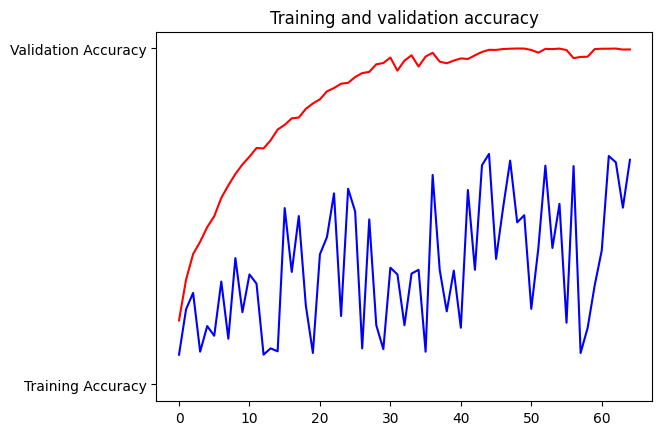

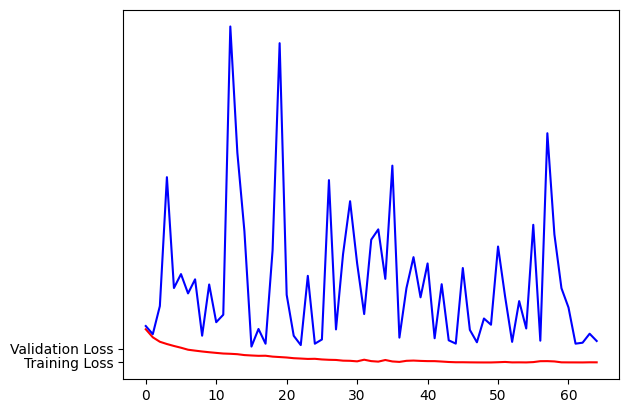

In [9]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc_mobile=train_mobile.history['accuracy']
val_acc_mobile=train_mobile.history['val_accuracy']
loss_mobile=train_mobile.history['loss']
val_loss_mobile=train_mobile.history['val_loss']

epochs2=range(len(acc_mobile)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs2, acc_mobile, 'r', "Training Accuracy")
plt.plot(epochs2, val_acc_mobile, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs2, loss_mobile, 'r', "Training Loss")
plt.plot(epochs2, val_loss_mobile, 'b', "Validation Loss")
plt.show()

#### 0,4

In [9]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
#pretrained_mobile.trainable = False
sgd = tf.keras.optimizers.SGD(learning_rate=0.4)
adam = tf.keras.optimizers.Adam(learning_rate=1e-6)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=["accuracy"])

filepath = 'new_test/new-test-resnet-sgd-0,4.h5'

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'max',
    save_freq = 'epoch'
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    verbose=1,
)
train_log=tf.keras.callbacks.CSVLogger(
    filename='new_test/new-test-resnet-sgd-0,4.log', 
    separator=','
)
callbacksList = [modelCheckpoint, train_log]
train_mobile = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=100,
                    callbacks = callbacksList,
                    verbose=1)
model.save('new_test/new-test-resnet-sgd-0,4-completed.h5')

Epoch 1/100


2024-01-03 18:04:14.463746: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2024-01-03 18:04:15.153136: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-03 18:04:15.339849: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-03 18:04:16.061281: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x556873e8cc10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-03 18:04:16.061342: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2024-01-03 18:04:16.187872: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


453/453 [==============================] - ETA: 0s - loss: 2.1320 - accuracy: 0.2403
Epoch 1: val_accuracy improved from -inf to 0.09875, saving model to new_test/new-test-resnet-sgd-0,4.h5


/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


453/453 [==============================] - 160s 228ms/step - loss: 2.1320 - accuracy: 0.2403 - val_loss: 2.5686 - val_accuracy: 0.0988
Epoch 2/100
453/453 [==============================] - ETA: 0s - loss: 1.4628 - accuracy: 0.3949
Epoch 2: val_accuracy did not improve from 0.09875
453/453 [==============================] - 100s 221ms/step - loss: 1.4628 - accuracy: 0.3949 - val_loss: 18.0480 - val_accuracy: 0.0712
Epoch 3/100
453/453 [==============================] - ETA: 0s - loss: 1.2122 - accuracy: 0.4585
Epoch 3: val_accuracy improved from 0.09875 to 0.28375, saving model to new_test/new-test-resnet-sgd-0,4.h5
453/453 [==============================] - 101s 222ms/step - loss: 1.2122 - accuracy: 0.4585 - val_loss: 2.2886 - val_accuracy: 0.2837
Epoch 4/100
453/453 [==============================] - ETA: 0s - loss: 1.0699 - accuracy: 0.5102
Epoch 4: val_accuracy improved from 0.28375 to 0.40625, saving model to new_test/new-test-resnet-sgd-0,4.h5
453/453 [===========================

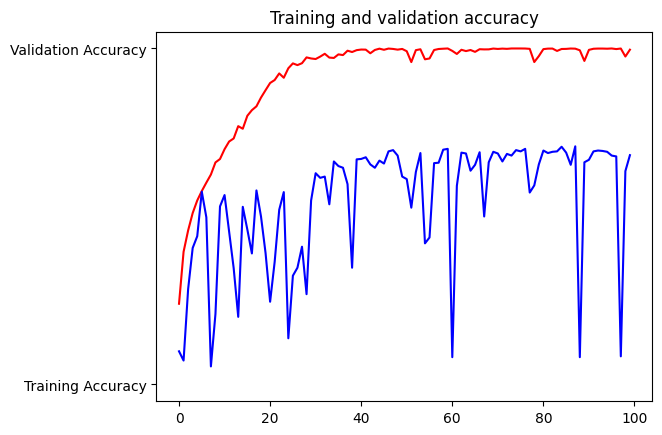

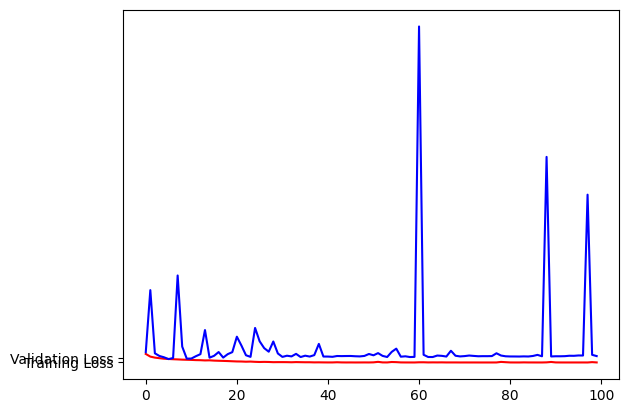

In [10]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc_mobile=train_mobile.history['accuracy']
val_acc_mobile=train_mobile.history['val_accuracy']
loss_mobile=train_mobile.history['loss']
val_loss_mobile=train_mobile.history['val_loss']

epochs2=range(len(acc_mobile)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs2, acc_mobile, 'r', "Training Accuracy")
plt.plot(epochs2, val_acc_mobile, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs2, loss_mobile, 'r', "Training Loss")
plt.plot(epochs2, val_loss_mobile, 'b', "Validation Loss")
plt.show()

### 0,01 - 0,04

#### 0,01

In [9]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.01)
adam = tf.keras.optimizers.Adam(learning_rate=1e-6)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=["accuracy"])

filepath = 'new_test/new-test-mobile-sgd-0,01.h5'

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'max',
    save_freq = 'epoch'
)
train_log=tf.keras.callbacks.CSVLogger(
    filename='new_test/new-test-mobile-sgd-0,01.log', 
    separator=','
)
callbacksList = [modelCheckpoint, train_log]
train_mobile = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=50,
                    callbacks = callbacksList,
                    verbose=1)

Epoch 1/50


2023-12-19 19:28:17.086677: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2023-12-19 19:28:20.244439: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-19 19:28:20.735291: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-19 19:28:30.898406: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x559123ff60e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-19 19:28:30.898469: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2023-12-19 19:28:31.025906: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


227/227 [==============================] - ETA: 0s - loss: 1.5556 - accuracy: 0.4300
Epoch 1: val_accuracy improved from -inf to 0.22375, saving model to new_test/new-test-mobile-sgd-0,01.h5


/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


227/227 [==============================] - 93s 223ms/step - loss: 1.5556 - accuracy: 0.4300 - val_loss: 2.3254 - val_accuracy: 0.2237
Epoch 2/50
227/227 [==============================] - ETA: 0s - loss: 0.8726 - accuracy: 0.6327
Epoch 2: val_accuracy improved from 0.22375 to 0.25500, saving model to new_test/new-test-mobile-sgd-0,01.h5
227/227 [==============================] - 28s 124ms/step - loss: 0.8726 - accuracy: 0.6327 - val_loss: 2.2431 - val_accuracy: 0.2550
Epoch 3/50
227/227 [==============================] - ETA: 0s - loss: 0.6694 - accuracy: 0.7126
Epoch 3: val_accuracy improved from 0.25500 to 0.30250, saving model to new_test/new-test-mobile-sgd-0,01.h5
227/227 [==============================] - 28s 122ms/step - loss: 0.6694 - accuracy: 0.7126 - val_loss: 2.1422 - val_accuracy: 0.3025
Epoch 4/50
227/227 [==============================] - ETA: 0s - loss: 0.5663 - accuracy: 0.7569
Epoch 4: val_accuracy improved from 0.30250 to 0.36125, saving model to new_test/new-test-mo

In [12]:
model.save('new_test/new-test-mobile-sgd-0,01-completed.h5')

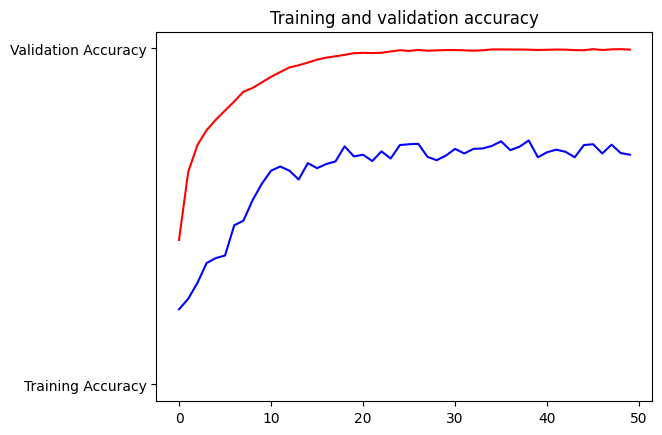

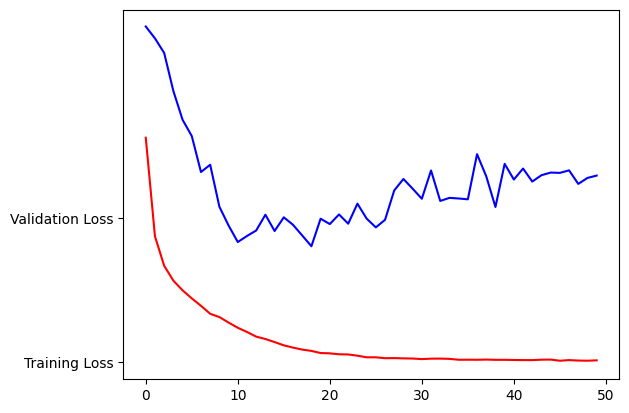

In [13]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc_mobile=train_mobile.history['accuracy']
val_acc_mobile=train_mobile.history['val_accuracy']
loss_mobile=train_mobile.history['loss']
val_loss_mobile=train_mobile.history['val_loss']

epochs2=range(len(acc_mobile)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs2, acc_mobile, 'r', "Training Accuracy")
plt.plot(epochs2, val_acc_mobile, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs2, loss_mobile, 'r', "Training Loss")
plt.plot(epochs2, val_loss_mobile, 'b', "Validation Loss")
plt.show()

#### 0,02

In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
#pretrained_mobile.trainable = False
sgd = tf.keras.optimizers.SGD(learning_rate=0.02)
adam = tf.keras.optimizers.Adam(learning_rate=1e-6)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=["accuracy"])

filepath = 'new_test/new-test-mobile-sgd-0,02.h5'

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'max',
    save_freq = 'epoch'
)
train_log=tf.keras.callbacks.CSVLogger(
    filename='new_test/new-test-mobile-sgd-0,02.log', 
    separator=','
)
callbacksList = [modelCheckpoint, train_log]
train_mobile = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=50,
                    callbacks = callbacksList,
                    verbose=1)
model.save('new_test/new-test-mobile-sgd-0,02-completed.h5')

Epoch 1/50


2023-12-19 19:55:08.466101: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2023-12-19 19:55:11.429215: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-19 19:55:11.758630: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-19 19:55:21.292802: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x555879496cf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-19 19:55:21.292853: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2023-12-19 19:55:21.404240: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


227/227 [==============================] - ETA: 0s - loss: 1.2429 - accuracy: 0.5276
Epoch 1: val_accuracy improved from -inf to 0.16625, saving model to new_test/new-test-mobile-sgd-0,02.h5


/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


227/227 [==============================] - 92s 223ms/step - loss: 1.2429 - accuracy: 0.5276 - val_loss: 2.4043 - val_accuracy: 0.1663
Epoch 2/50
227/227 [==============================] - ETA: 0s - loss: 0.6552 - accuracy: 0.7057
Epoch 2: val_accuracy improved from 0.16625 to 0.23625, saving model to new_test/new-test-mobile-sgd-0,02.h5
227/227 [==============================] - 27s 117ms/step - loss: 0.6552 - accuracy: 0.7057 - val_loss: 2.0650 - val_accuracy: 0.2362
Epoch 3/50
227/227 [==============================] - ETA: 0s - loss: 0.5175 - accuracy: 0.7716
Epoch 3: val_accuracy improved from 0.23625 to 0.27750, saving model to new_test/new-test-mobile-sgd-0,02.h5
227/227 [==============================] - 27s 120ms/step - loss: 0.5175 - accuracy: 0.7716 - val_loss: 1.9832 - val_accuracy: 0.2775
Epoch 4/50
227/227 [==============================] - ETA: 0s - loss: 0.4371 - accuracy: 0.8100
Epoch 4: val_accuracy improved from 0.27750 to 0.34375, saving model to new_test/new-test-mo

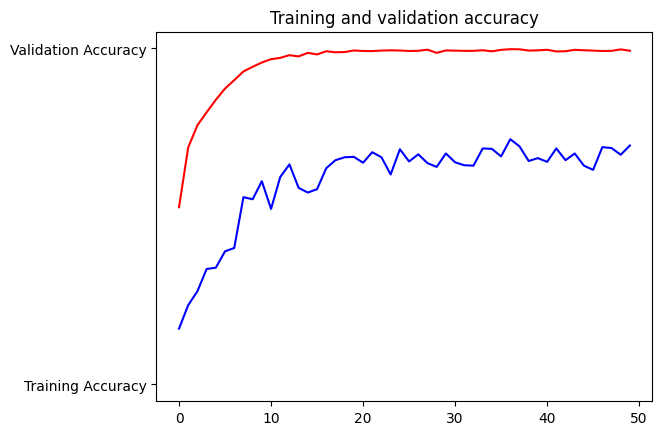

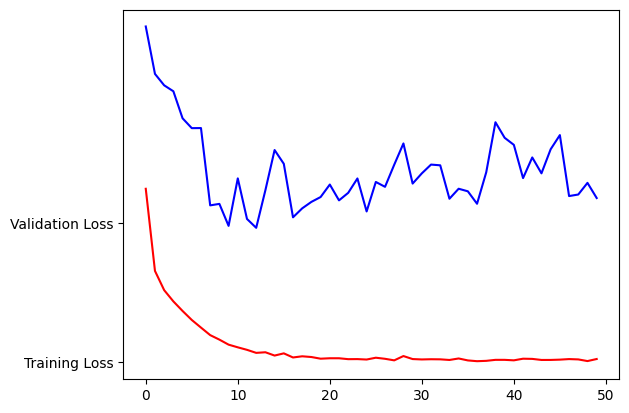

In [9]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc_mobile=train_mobile.history['accuracy']
val_acc_mobile=train_mobile.history['val_accuracy']
loss_mobile=train_mobile.history['loss']
val_loss_mobile=train_mobile.history['val_loss']

epochs2=range(len(acc_mobile)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs2, acc_mobile, 'r', "Training Accuracy")
plt.plot(epochs2, val_acc_mobile, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs2, loss_mobile, 'r', "Training Loss")
plt.plot(epochs2, val_loss_mobile, 'b', "Validation Loss")
plt.show()

#### 0,03

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
#pretrained_mobile.trainable = False
sgd = tf.keras.optimizers.SGD(learning_rate=0.03)
adam = tf.keras.optimizers.Adam(learning_rate=1e-6)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=["accuracy"])

filepath = 'new_test/new-test-mobile-sgd-0,03.h5'

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'max',
    save_freq = 'epoch'
)
train_log=tf.keras.callbacks.CSVLogger(
    filename='new_test/new-test-mobile-sgd-0,03.log', 
    separator=','
)
callbacksList = [modelCheckpoint, train_log]
train_mobile = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=50,
                    callbacks = callbacksList,
                    verbose=1)
model.save('new_test/new-test-mobile-sgd-0,03-completed.h5')

Epoch 1/50


2023-12-19 20:58:05.803373: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2023-12-19 20:58:09.005516: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-19 20:58:09.487764: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-19 20:58:19.583388: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f12bc5bb780 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-19 20:58:19.583413: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2023-12-19 20:58:19.695312: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


227/227 [==============================] - ETA: 0s - loss: 1.1296 - accuracy: 0.5450
Epoch 1: val_accuracy improved from -inf to 0.36125, saving model to new_test/new-test-mobile-sgd-0,03.h5


/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


227/227 [==============================] - 92s 218ms/step - loss: 1.1296 - accuracy: 0.5450 - val_loss: 1.9636 - val_accuracy: 0.3613
Epoch 2/50
227/227 [==============================] - ETA: 0s - loss: 0.6342 - accuracy: 0.7094
Epoch 2: val_accuracy improved from 0.36125 to 0.37875, saving model to new_test/new-test-mobile-sgd-0,03.h5
227/227 [==============================] - 27s 117ms/step - loss: 0.6342 - accuracy: 0.7094 - val_loss: 1.8941 - val_accuracy: 0.3787
Epoch 3/50
227/227 [==============================] - ETA: 0s - loss: 0.4864 - accuracy: 0.7835
Epoch 3: val_accuracy did not improve from 0.37875
227/227 [==============================] - 26s 116ms/step - loss: 0.4864 - accuracy: 0.7835 - val_loss: 2.3890 - val_accuracy: 0.2500
Epoch 4/50
227/227 [==============================] - ETA: 0s - loss: 0.3952 - accuracy: 0.8283
Epoch 4: val_accuracy did not improve from 0.37875
227/227 [==============================] - 27s 119ms/step - loss: 0.3952 - accuracy: 0.8283 - val_l

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc_mobile=train_mobile.history['accuracy']
val_acc_mobile=train_mobile.history['val_accuracy']
loss_mobile=train_mobile.history['loss']
val_loss_mobile=train_mobile.history['val_loss']

epochs2=range(len(acc_mobile)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs2, acc_mobile, 'r', "Training Accuracy")
plt.plot(epochs2, val_acc_mobile, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs2, loss_mobile, 'r', "Training Loss")
plt.plot(epochs2, val_loss_mobile, 'b', "Validation Loss")
plt.show()

#### 0,04

In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
#pretrained_mobile.trainable = False
sgd = tf.keras.optimizers.SGD(learning_rate=0.04)
adam = tf.keras.optimizers.Adam(learning_rate=1e-6)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=["accuracy"])

filepath = 'new_test/new-test-mobile-sgd-0,04.h5'

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'max',
    save_freq = 'epoch'
)
train_log=tf.keras.callbacks.CSVLogger(
    filename='new_test/new-test-mobile-sgd-0,04.log', 
    separator=','
)
callbacksList = [modelCheckpoint, train_log]
train_mobile = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=50,
                    callbacks = callbacksList,
                    verbose=1)
model.save('new_test/new-test-mobile-sgd-0,04-completed.h5')

Epoch 1/50


2023-12-19 21:34:44.479781: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2023-12-19 21:34:47.690875: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-19 21:34:48.208058: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-19 21:34:58.332453: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55629343ab60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-19 21:34:58.332528: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2023-12-19 21:34:58.450194: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


227/227 [==============================] - ETA: 0s - loss: 1.0669 - accuracy: 0.5580
Epoch 1: val_accuracy improved from -inf to 0.29125, saving model to new_test/new-test-mobile-sgd-0,04.h5


/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


227/227 [==============================] - 92s 216ms/step - loss: 1.0669 - accuracy: 0.5580 - val_loss: 2.0208 - val_accuracy: 0.2912
Epoch 2/50
227/227 [==============================] - ETA: 0s - loss: 0.6026 - accuracy: 0.7217
Epoch 2: val_accuracy did not improve from 0.29125
227/227 [==============================] - 28s 122ms/step - loss: 0.6026 - accuracy: 0.7217 - val_loss: 2.2752 - val_accuracy: 0.2812
Epoch 3/50
227/227 [==============================] - ETA: 0s - loss: 0.4709 - accuracy: 0.7928
Epoch 3: val_accuracy did not improve from 0.29125
227/227 [==============================] - 27s 120ms/step - loss: 0.4709 - accuracy: 0.7928 - val_loss: 2.5010 - val_accuracy: 0.2825
Epoch 4/50
227/227 [==============================] - ETA: 0s - loss: 0.3840 - accuracy: 0.8340
Epoch 4: val_accuracy did not improve from 0.29125
227/227 [==============================] - 27s 118ms/step - loss: 0.3840 - accuracy: 0.8340 - val_loss: 3.0781 - val_accuracy: 0.2800
Epoch 5/50
227/227 [===

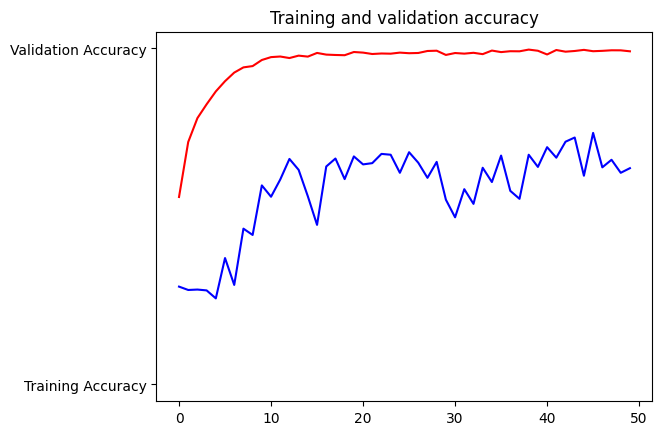

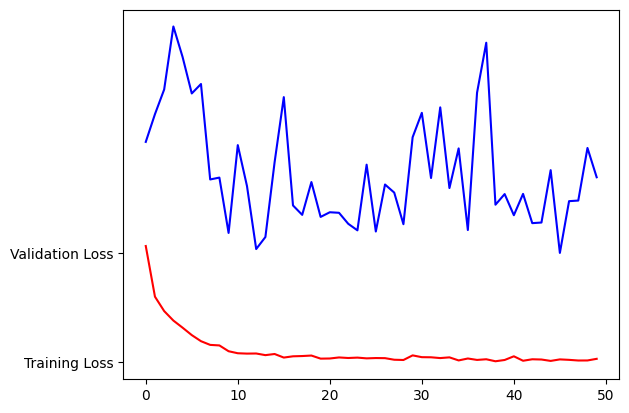

In [9]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc_mobile=train_mobile.history['accuracy']
val_acc_mobile=train_mobile.history['val_accuracy']
loss_mobile=train_mobile.history['loss']
val_loss_mobile=train_mobile.history['val_loss']

epochs2=range(len(acc_mobile)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs2, acc_mobile, 'r', "Training Accuracy")
plt.plot(epochs2, val_acc_mobile, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs2, loss_mobile, 'r', "Training Loss")
plt.plot(epochs2, val_loss_mobile, 'b', "Validation Loss")
plt.show()

### 0,001 - 0,004

#### 0,001

In [8]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.001)
adam = tf.keras.optimizers.Adam(learning_rate=1e-6)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=["accuracy"])

filepath = 'new_test/new-test-mobile-sgd-0,001.h5'

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'max',
    save_freq = 'epoch'
)
train_log=tf.keras.callbacks.CSVLogger(
    filename='new_test/new-test-mobile-sgd-0,001.log', 
    separator=','
)
callbacksList = [modelCheckpoint, train_log]
train_mobile = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=50,
                    callbacks = callbacksList,
                    verbose=1)
model.save('new_test/new-test-mobile-sgd-0,001-completed.h5')

Epoch 1/50


2023-12-19 22:13:08.541181: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2023-12-19 22:13:11.802405: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-19 22:13:12.289067: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-19 22:13:22.644095: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f529e88d0f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-19 22:13:22.644145: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2023-12-19 22:13:22.760624: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


227/227 [==============================] - ETA: 0s - loss: 2.5047 - accuracy: 0.1497
Epoch 1: val_accuracy improved from -inf to 0.12625, saving model to new_test/new-test-mobile-sgd-0,001.h5


/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


227/227 [==============================] - 92s 218ms/step - loss: 2.5047 - accuracy: 0.1497 - val_loss: 2.5261 - val_accuracy: 0.1262
Epoch 2/50
227/227 [==============================] - ETA: 0s - loss: 2.0630 - accuracy: 0.3097
Epoch 2: val_accuracy improved from 0.12625 to 0.18375, saving model to new_test/new-test-mobile-sgd-0,001.h5
227/227 [==============================] - 28s 121ms/step - loss: 2.0630 - accuracy: 0.3097 - val_loss: 2.3642 - val_accuracy: 0.1838
Epoch 3/50
227/227 [==============================] - ETA: 0s - loss: 1.7957 - accuracy: 0.3939
Epoch 3: val_accuracy improved from 0.18375 to 0.21625, saving model to new_test/new-test-mobile-sgd-0,001.h5
227/227 [==============================] - 27s 121ms/step - loss: 1.7957 - accuracy: 0.3939 - val_loss: 2.2360 - val_accuracy: 0.2163
Epoch 4/50
227/227 [==============================] - ETA: 0s - loss: 1.6146 - accuracy: 0.4514
Epoch 4: val_accuracy improved from 0.21625 to 0.24875, saving model to new_test/new-test-

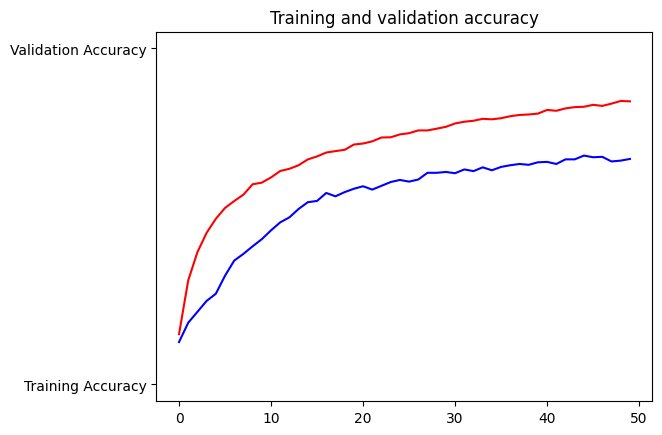

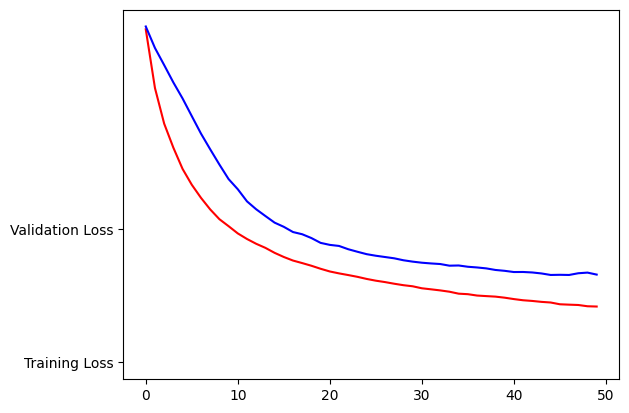

In [9]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc_mobile=train_mobile.history['accuracy']
val_acc_mobile=train_mobile.history['val_accuracy']
loss_mobile=train_mobile.history['loss']
val_loss_mobile=train_mobile.history['val_loss']

epochs2=range(len(acc_mobile)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs2, acc_mobile, 'r', "Training Accuracy")
plt.plot(epochs2, val_acc_mobile, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs2, loss_mobile, 'r', "Training Loss")
plt.plot(epochs2, val_loss_mobile, 'b', "Validation Loss")
plt.show()

#### 0,002

In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
#pretrained_mobile.trainable = False
sgd = tf.keras.optimizers.SGD(learning_rate=0.002)
adam = tf.keras.optimizers.Adam(learning_rate=1e-6)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=["accuracy"])

filepath = 'new_test/new-test-mobile-sgd-0,002.h5'

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'max',
    save_freq = 'epoch'
)
train_log=tf.keras.callbacks.CSVLogger(
    filename='new_test/new-test-mobile-sgd-0,002.log', 
    separator=','
)
callbacksList = [modelCheckpoint, train_log]
train_mobile = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=50,
                    callbacks = callbacksList,
                    verbose=1)
model.save('new_test/new-test-mobile-sgd-0,002-completed.h5')

Epoch 1/50


2023-12-19 22:40:15.101545: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2023-12-19 22:40:18.289177: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-19 22:40:18.801285: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-19 22:40:28.759947: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd37c13a570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-19 22:40:28.759980: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2023-12-19 22:40:28.882461: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


227/227 [==============================] - ETA: 0s - loss: 2.2047 - accuracy: 0.2408
Epoch 1: val_accuracy improved from -inf to 0.19625, saving model to new_test/new-test-mobile-sgd-0,002.h5


/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


227/227 [==============================] - 94s 225ms/step - loss: 2.2047 - accuracy: 0.2408 - val_loss: 2.4739 - val_accuracy: 0.1963
Epoch 2/50
227/227 [==============================] - ETA: 0s - loss: 1.6927 - accuracy: 0.4170
Epoch 2: val_accuracy improved from 0.19625 to 0.26625, saving model to new_test/new-test-mobile-sgd-0,002.h5
227/227 [==============================] - 28s 121ms/step - loss: 1.6927 - accuracy: 0.4170 - val_loss: 2.2082 - val_accuracy: 0.2663
Epoch 3/50
227/227 [==============================] - ETA: 0s - loss: 1.3678 - accuracy: 0.4998
Epoch 3: val_accuracy improved from 0.26625 to 0.32875, saving model to new_test/new-test-mobile-sgd-0,002.h5
227/227 [==============================] - 28s 124ms/step - loss: 1.3678 - accuracy: 0.4998 - val_loss: 2.0175 - val_accuracy: 0.3288
Epoch 4/50
227/227 [==============================] - ETA: 0s - loss: 1.1744 - accuracy: 0.5573
Epoch 4: val_accuracy improved from 0.32875 to 0.35750, saving model to new_test/new-test-

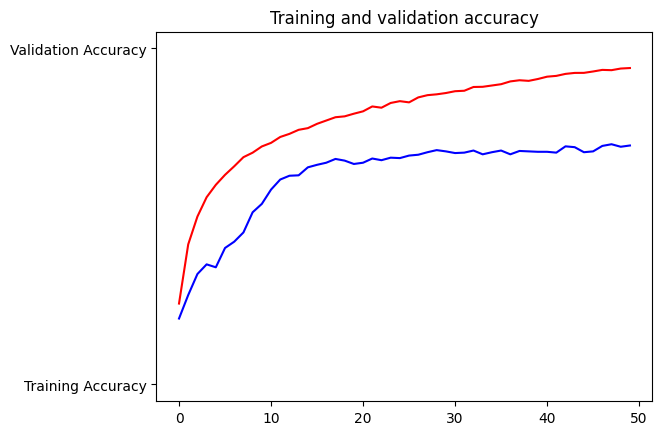

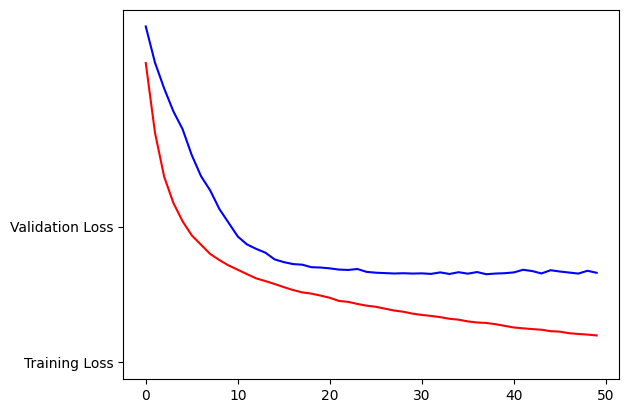

In [9]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc_mobile=train_mobile.history['accuracy']
val_acc_mobile=train_mobile.history['val_accuracy']
loss_mobile=train_mobile.history['loss']
val_loss_mobile=train_mobile.history['val_loss']

epochs2=range(len(acc_mobile)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs2, acc_mobile, 'r', "Training Accuracy")
plt.plot(epochs2, val_acc_mobile, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs2, loss_mobile, 'r', "Training Loss")
plt.plot(epochs2, val_loss_mobile, 'b', "Validation Loss")
plt.show()

#### 0,003

In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
#pretrained_mobile.trainable = False
sgd = tf.keras.optimizers.SGD(learning_rate=0.003)
adam = tf.keras.optimizers.Adam(learning_rate=1e-6)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=["accuracy"])

filepath = 'new_test/new-test-mobile-sgd-0,003.h5'

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'max',
    save_freq = 'epoch'
)
train_log=tf.keras.callbacks.CSVLogger(
    filename='new_test/new-test-mobile-sgd-0,003.log', 
    separator=','
)
callbacksList = [modelCheckpoint, train_log]
train_mobile = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=50,
                    callbacks = callbacksList,
                    verbose=1)
model.save('new_test/new-test-mobile-sgd-0,003-completed.h5')

Epoch 1/50


2023-12-19 23:05:27.264444: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2023-12-19 23:05:30.468010: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-19 23:05:30.974590: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-19 23:05:41.072228: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f62146dd240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-19 23:05:41.072259: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2023-12-19 23:05:41.178961: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


227/227 [==============================] - ETA: 0s - loss: 2.0817 - accuracy: 0.2923
Epoch 1: val_accuracy improved from -inf to 0.20875, saving model to new_test/new-test-mobile-sgd-0,003.h5


/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


227/227 [==============================] - 93s 220ms/step - loss: 2.0817 - accuracy: 0.2923 - val_loss: 2.2472 - val_accuracy: 0.2087
Epoch 2/50
227/227 [==============================] - ETA: 0s - loss: 1.4518 - accuracy: 0.4864
Epoch 2: val_accuracy improved from 0.20875 to 0.29250, saving model to new_test/new-test-mobile-sgd-0,003.h5
227/227 [==============================] - 27s 120ms/step - loss: 1.4518 - accuracy: 0.4864 - val_loss: 1.9772 - val_accuracy: 0.2925
Epoch 3/50
227/227 [==============================] - ETA: 0s - loss: 1.1390 - accuracy: 0.5700
Epoch 3: val_accuracy improved from 0.29250 to 0.33250, saving model to new_test/new-test-mobile-sgd-0,003.h5
227/227 [==============================] - 27s 119ms/step - loss: 1.1390 - accuracy: 0.5700 - val_loss: 1.7859 - val_accuracy: 0.3325
Epoch 4/50
227/227 [==============================] - ETA: 0s - loss: 0.9612 - accuracy: 0.6187
Epoch 4: val_accuracy improved from 0.33250 to 0.36875, saving model to new_test/new-test-

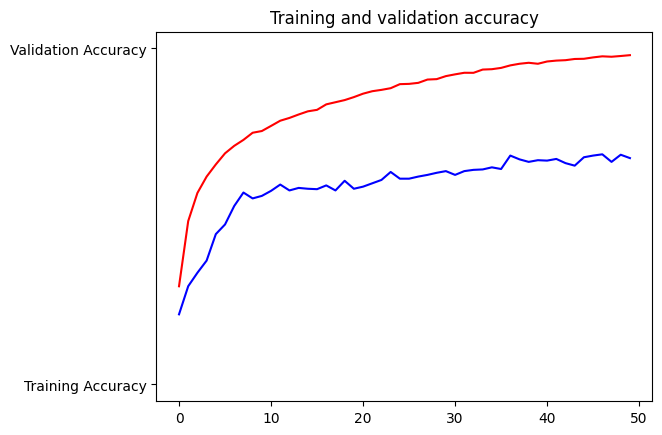

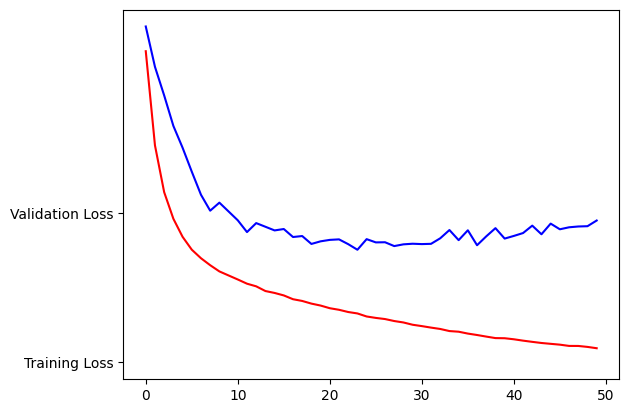

In [9]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc_mobile=train_mobile.history['accuracy']
val_acc_mobile=train_mobile.history['val_accuracy']
loss_mobile=train_mobile.history['loss']
val_loss_mobile=train_mobile.history['val_loss']

epochs2=range(len(acc_mobile)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs2, acc_mobile, 'r', "Training Accuracy")
plt.plot(epochs2, val_acc_mobile, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs2, loss_mobile, 'r', "Training Loss")
plt.plot(epochs2, val_loss_mobile, 'b', "Validation Loss")
plt.show()

#### 0,004

In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
#pretrained_mobile.trainable = False
sgd = tf.keras.optimizers.SGD(learning_rate=0.004)
adam = tf.keras.optimizers.Adam(learning_rate=1e-6)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=["accuracy"])

filepath = 'new_test/new-test-mobile-sgd-0,004.h5'

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'max',
    save_freq = 'epoch'
)
train_log=tf.keras.callbacks.CSVLogger(
    filename='new_test/new-test-mobile-sgd-0,004.log', 
    separator=','
)
callbacksList = [modelCheckpoint, train_log]
train_mobile = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=50,
                    callbacks = callbacksList,
                    verbose=1)
model.save('new_test/new-test-mobile-sgd-0,004-completed.h5')

Epoch 1/50


2023-12-19 23:31:42.926619: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2023-12-19 23:31:46.032057: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-19 23:31:46.518246: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-19 23:31:56.657192: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55fd67c816b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-19 23:31:56.657253: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2023-12-19 23:31:56.782031: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


227/227 [==============================] - ETA: 0s - loss: 1.9463 - accuracy: 0.3328
Epoch 1: val_accuracy improved from -inf to 0.19125, saving model to new_test/new-test-mobile-sgd-0,004.h5


/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


227/227 [==============================] - 93s 224ms/step - loss: 1.9463 - accuracy: 0.3328 - val_loss: 2.3827 - val_accuracy: 0.1912
Epoch 2/50
227/227 [==============================] - ETA: 0s - loss: 1.2537 - accuracy: 0.5291
Epoch 2: val_accuracy improved from 0.19125 to 0.25500, saving model to new_test/new-test-mobile-sgd-0,004.h5
227/227 [==============================] - 27s 121ms/step - loss: 1.2537 - accuracy: 0.5291 - val_loss: 2.0349 - val_accuracy: 0.2550
Epoch 3/50
227/227 [==============================] - ETA: 0s - loss: 0.9643 - accuracy: 0.6112
Epoch 3: val_accuracy improved from 0.25500 to 0.32875, saving model to new_test/new-test-mobile-sgd-0,004.h5
227/227 [==============================] - 28s 122ms/step - loss: 0.9643 - accuracy: 0.6112 - val_loss: 1.7675 - val_accuracy: 0.3288
Epoch 4/50
227/227 [==============================] - ETA: 0s - loss: 0.8169 - accuracy: 0.6573
Epoch 4: val_accuracy improved from 0.32875 to 0.37125, saving model to new_test/new-test-

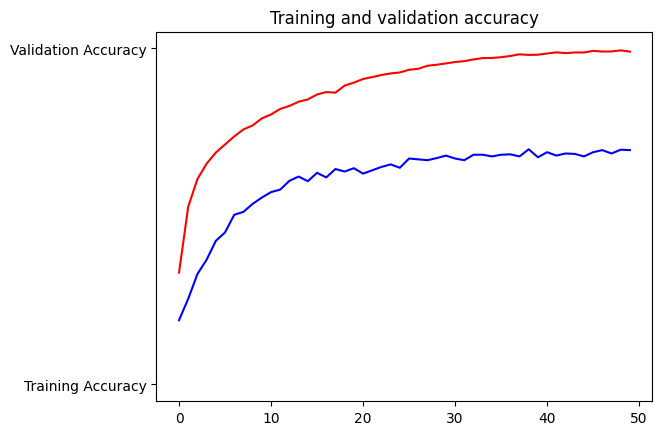

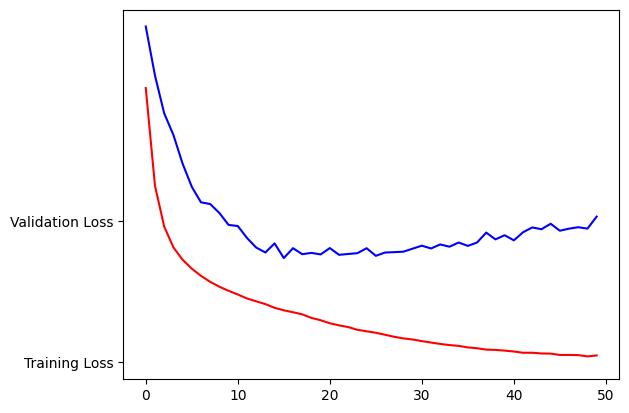

In [9]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc_mobile=train_mobile.history['accuracy']
val_acc_mobile=train_mobile.history['val_accuracy']
loss_mobile=train_mobile.history['loss']
val_loss_mobile=train_mobile.history['val_loss']

epochs2=range(len(acc_mobile)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs2, acc_mobile, 'r', "Training Accuracy")
plt.plot(epochs2, val_acc_mobile, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs2, loss_mobile, 'r', "Training Loss")
plt.plot(epochs2, val_loss_mobile, 'b', "Validation Loss")
plt.show()

### 0,0001 - 0,0004

#### 0,0001

In [ ]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.0001)
adam = tf.keras.optimizers.Adam(learning_rate=1e-6)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=["accuracy"])

filepath = 'new_test/new-test-resnet-sgd-0,0001.h5'

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'max',
    save_freq = 'epoch'
)
train_log=tf.keras.callbacks.CSVLogger(
    filename='new_test/new-test-resnet-sgd-0,0001.log', 
    separator=','
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    verbose=1,
) 
callbacksList = [modelCheckpoint, train_log, early_stopping]
train_mobile = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=100,
                    callbacks = callbacksList,
                    verbose=1)
model.save('new_test/new-test-resnet-sgd-0,0001-completed.h5')

Epoch 1/100


2023-12-28 14:12:43.046453: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2023-12-28 14:12:44.469173: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-28 14:12:44.838032: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-28 14:12:51.641966: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5577c7929b90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-28 14:12:51.642042: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2023-12-28 14:12:51.769515: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


453/453 [==============================] - ETA: 0s - loss: 2.3646 - accuracy: 0.2049
Epoch 1: val_accuracy improved from -inf to 0.07250, saving model to new_test/new-test-resnet-sgd-0,0001.h5


/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


453/453 [==============================] - 377s 657ms/step - loss: 2.3646 - accuracy: 0.2049 - val_loss: 4.8296 - val_accuracy: 0.0725
Epoch 2/100
453/453 [==============================] - ETA: 0s - loss: 1.8679 - accuracy: 0.3944
Epoch 2: val_accuracy improved from 0.07250 to 0.14375, saving model to new_test/new-test-resnet-sgd-0,0001.h5
453/453 [==============================] - 234s 515ms/step - loss: 1.8679 - accuracy: 0.3944 - val_loss: 2.9004 - val_accuracy: 0.1437
Epoch 3/100
453/453 [==============================] - ETA: 0s - loss: 1.5871 - accuracy: 0.4824
Epoch 3: val_accuracy improved from 0.14375 to 0.39625, saving model to new_test/new-test-resnet-sgd-0,0001.h5
453/453 [==============================] - 232s 512ms/step - loss: 1.5871 - accuracy: 0.4824 - val_loss: 1.7228 - val_accuracy: 0.3963
Epoch 4/100
453/453 [==============================] - ETA: 0s - loss: 1.3882 - accuracy: 0.5360
Epoch 4: val_accuracy improved from 0.39625 to 0.43125, saving model to new_test/n

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
# Replace with the path to your saved model
model_resnet = load_model('new_test/new-test-resnet-sgd-0,0001.h5')

sgd = tf.keras.optimizers.SGD(learning_rate=0.1)
model_resnet.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=["accuracy"])

initial_epoch = 78  # Set this to the last completed epoch number
total_epochs = 100  # Adjust as needed

filepath = 'new_test/new-test-resnet-sgd-0,0001-checkpoint.h5'

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'max',
    save_freq = 'epoch'
)
train_log=tf.keras.callbacks.CSVLogger(
    filename='new-test-resnet-sgd-0,0001.log', 
    separator=','
)
callbacksList = [modelCheckpoint, train_log]

train_resnet = model_resnet.fit(train_generator,
                                validation_data=validation_generator,
                                epochs=total_epochs,
                                initial_epoch=initial_epoch,
                                callbacks=callbacksList,
                                verbose=1)

2023-12-28 19:26:07.443682: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 25402 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:af:00.0, compute capability: 7.5


Epoch 79/100


2023-12-28 19:26:51.349819: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2023-12-28 19:26:53.543313: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-28 19:26:53.783424: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-28 19:26:58.479173: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f7774010310 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-28 19:26:58.479244: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2023-12-28 19:26:58.608180: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


425/453 [===========================>..] - ETA: 15s - loss: 1.2637 - accuracy: 0.4957

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc_mobile=train_mobile.history['accuracy']
val_acc_mobile=train_mobile.history['val_accuracy']
loss_mobile=train_mobile.history['loss']
val_loss_mobile=train_mobile.history['val_loss']

epochs2=range(len(acc_mobile)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs2, acc_mobile, 'r', "Training Accuracy")
plt.plot(epochs2, val_acc_mobile, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs2, loss_mobile, 'r', "Training Loss")
plt.plot(epochs2, val_loss_mobile, 'b', "Validation Loss")
plt.show()

#### 0,0002

In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
#pretrained_mobile.trainable = False
sgd = tf.keras.optimizers.SGD(learning_rate=0.0002)
adam = tf.keras.optimizers.Adam(learning_rate=1e-6)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=["accuracy"])

filepath = 'new_test/new-test-mobile-sgd-0,0002.h5'

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'max',
    save_freq = 'epoch'
)
train_log=tf.keras.callbacks.CSVLogger(
    filename='new_test/new-test-mobile-sgd-0,0002.log', 
    separator=','
)
callbacksList = [modelCheckpoint, train_log]
train_mobile = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=50,
                    callbacks = callbacksList,
                    verbose=1)
model.save('new_test/new-test-mobile-sgd-0,0002-completed.h5')

Epoch 1/50


2023-12-20 00:25:31.390161: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2023-12-20 00:25:34.550020: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-20 00:25:35.040828: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-20 00:25:45.148544: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fbf0e93c900 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-20 00:25:45.148573: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2023-12-20 00:25:45.256883: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


227/227 [==============================] - ETA: 0s - loss: 2.5990 - accuracy: 0.0910
Epoch 1: val_accuracy improved from -inf to 0.08875, saving model to new_test/new-test-mobile-sgd-0,0002.h5


/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


227/227 [==============================] - 92s 220ms/step - loss: 2.5990 - accuracy: 0.0910 - val_loss: 3.0952 - val_accuracy: 0.0887
Epoch 2/50
227/227 [==============================] - ETA: 0s - loss: 2.4678 - accuracy: 0.1464
Epoch 2: val_accuracy improved from 0.08875 to 0.11000, saving model to new_test/new-test-mobile-sgd-0,0002.h5
227/227 [==============================] - 28s 121ms/step - loss: 2.4678 - accuracy: 0.1464 - val_loss: 2.9150 - val_accuracy: 0.1100
Epoch 3/50
227/227 [==============================] - ETA: 0s - loss: 2.3677 - accuracy: 0.1875
Epoch 3: val_accuracy did not improve from 0.11000
227/227 [==============================] - 27s 121ms/step - loss: 2.3677 - accuracy: 0.1875 - val_loss: 2.8015 - val_accuracy: 0.1100
Epoch 4/50
227/227 [==============================] - ETA: 0s - loss: 2.2868 - accuracy: 0.2225
Epoch 4: val_accuracy did not improve from 0.11000
227/227 [==============================] - 27s 120ms/step - loss: 2.2868 - accuracy: 0.2225 - val

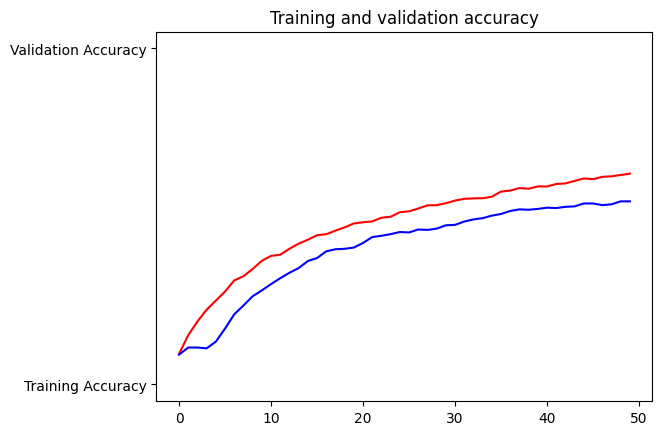

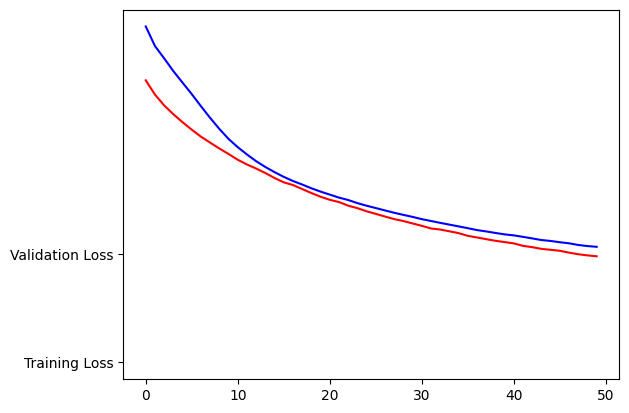

In [9]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc_mobile=train_mobile.history['accuracy']
val_acc_mobile=train_mobile.history['val_accuracy']
loss_mobile=train_mobile.history['loss']
val_loss_mobile=train_mobile.history['val_loss']

epochs2=range(len(acc_mobile)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs2, acc_mobile, 'r', "Training Accuracy")
plt.plot(epochs2, val_acc_mobile, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs2, loss_mobile, 'r', "Training Loss")
plt.plot(epochs2, val_loss_mobile, 'b', "Validation Loss")
plt.show()

#### 0,0003

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
#pretrained_mobile.trainable = False
sgd = tf.keras.optimizers.SGD(learning_rate=0.0003)
adam = tf.keras.optimizers.Adam(learning_rate=1e-6)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=["accuracy"])

filepath = 'new_test/new-test-mobile-sgd-0,0003.h5'

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'max',
    save_freq = 'epoch'
)
train_log=tf.keras.callbacks.CSVLogger(
    filename='new_test/new-test-mobile-sgd-0,0003.log', 
    separator=','
)
callbacksList = [modelCheckpoint, train_log]
train_mobile = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=50,
                    callbacks = callbacksList,
                    verbose=1)
model.save('new_test/new-test-mobile-sgd-0,0003-completed.h5')

Epoch 1/50


2023-12-20 07:40:53.462493: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2023-12-20 07:40:55.281776: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-20 07:40:55.610126: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-20 07:41:00.677343: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f566cd912a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-20 07:41:00.677384: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2023-12-20 07:41:00.797747: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


227/227 [==============================] - ETA: 0s - loss: 2.6091 - accuracy: 0.1073
Epoch 1: val_accuracy improved from -inf to 0.09875, saving model to new_test/new-test-mobile-sgd-0,0003.h5


/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


227/227 [==============================] - 68s 174ms/step - loss: 2.6091 - accuracy: 0.1073 - val_loss: 2.7608 - val_accuracy: 0.0988
Epoch 2/50
227/227 [==============================] - ETA: 0s - loss: 2.4003 - accuracy: 0.1698
Epoch 2: val_accuracy did not improve from 0.09875
227/227 [==============================] - 27s 119ms/step - loss: 2.4003 - accuracy: 0.1698 - val_loss: 2.6781 - val_accuracy: 0.0875
Epoch 3/50
227/227 [==============================] - ETA: 0s - loss: 2.2648 - accuracy: 0.2139
Epoch 3: val_accuracy did not improve from 0.09875
227/227 [==============================] - 29s 125ms/step - loss: 2.2648 - accuracy: 0.2139 - val_loss: 2.6116 - val_accuracy: 0.0825
Epoch 4/50
227/227 [==============================] - ETA: 0s - loss: 2.1552 - accuracy: 0.2623
Epoch 4: val_accuracy did not improve from 0.09875
227/227 [==============================] - 28s 122ms/step - loss: 2.1552 - accuracy: 0.2623 - val_loss: 2.5490 - val_accuracy: 0.0938
Epoch 5/50
227/227 [===

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc_mobile=train_mobile.history['accuracy']
val_acc_mobile=train_mobile.history['val_accuracy']
loss_mobile=train_mobile.history['loss']
val_loss_mobile=train_mobile.history['val_loss']

epochs2=range(len(acc_mobile)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs2, acc_mobile, 'r', "Training Accuracy")
plt.plot(epochs2, val_acc_mobile, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs2, loss_mobile, 'r', "Training Loss")
plt.plot(epochs2, val_loss_mobile, 'b', "Validation Loss")
plt.show()

#### 0,0004

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
#pretrained_mobile.trainable = False
sgd = tf.keras.optimizers.SGD(learning_rate=0.0004)
adam = tf.keras.optimizers.Adam(learning_rate=1e-6)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=["accuracy"])

filepath = 'new_test/new-test-mobile-sgd-0,0004.h5'

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'max',
    save_freq = 'epoch'
)
train_log=tf.keras.callbacks.CSVLogger(
    filename='new_test/new-test-mobile-sgd-0,0004.log', 
    separator=','
)
callbacksList = [modelCheckpoint, train_log]
train_mobile = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=50,
                    callbacks = callbacksList,
                    verbose=1)
model.save('new_test/new-test-mobile-sgd-0,0004-completed.h5')

Epoch 1/50


2023-12-20 08:08:41.515232: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2023-12-20 08:08:43.428340: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-20 08:08:43.935317: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-20 08:08:49.131294: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fe5a8cdb440 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-20 08:08:49.131323: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2023-12-20 08:08:49.241704: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


227/227 [==============================] - ETA: 0s - loss: 2.6242 - accuracy: 0.1113
Epoch 1: val_accuracy improved from -inf to 0.07375, saving model to new_test/new-test-mobile-sgd-0,0004.h5


/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


227/227 [==============================] - 69s 174ms/step - loss: 2.6242 - accuracy: 0.1113 - val_loss: 2.6140 - val_accuracy: 0.0737
Epoch 2/50
227/227 [==============================] - ETA: 0s - loss: 2.3347 - accuracy: 0.1998
Epoch 2: val_accuracy improved from 0.07375 to 0.11750, saving model to new_test/new-test-mobile-sgd-0,0004.h5
227/227 [==============================] - 29s 127ms/step - loss: 2.3347 - accuracy: 0.1998 - val_loss: 2.4655 - val_accuracy: 0.1175
Epoch 3/50
227/227 [==============================] - ETA: 0s - loss: 2.1734 - accuracy: 0.2628
Epoch 3: val_accuracy improved from 0.11750 to 0.18000, saving model to new_test/new-test-mobile-sgd-0,0004.h5
227/227 [==============================] - 26s 112ms/step - loss: 2.1734 - accuracy: 0.2628 - val_loss: 2.3401 - val_accuracy: 0.1800
Epoch 4/50
227/227 [==============================] - ETA: 0s - loss: 2.0369 - accuracy: 0.3140
Epoch 4: val_accuracy improved from 0.18000 to 0.24625, saving model to new_test/new-tes

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc_mobile=train_mobile.history['accuracy']
val_acc_mobile=train_mobile.history['val_accuracy']
loss_mobile=train_mobile.history['loss']
val_loss_mobile=train_mobile.history['val_loss']

epochs2=range(len(acc_mobile)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs2, acc_mobile, 'r', "Training Accuracy")
plt.plot(epochs2, val_acc_mobile, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs2, loss_mobile, 'r', "Training Loss")
plt.plot(epochs2, val_loss_mobile, 'b', "Validation Loss")
plt.show()